In [1]:
# import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)

import numpy as np
import pandas as pd
import fdsreader

from IPython.display import display
from PIL import Image

# Data Analysis II

This example demonstrates an analysis of slice data, here to determine the map of available safe egress time (ASET) and the temporal evolution of the smoke layer height. The used scenario is a multi-room appartment.

:::{figure-md} fig-example-dataanalysis2-scenario-geometry

<img src="figs/appartment_geometry.png" width="100%">

Visualization of the appartment geometry.
:::

````{admonition} Full FDS input file
:class: tip, dropdown
```{literalinclude} data/compartment/appartment_01/appartment.fds
```
````

````{admonition} Precomputed simulation data
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=compartment_appartment_01.zip)
````

As shown in [the introduction to fdsreader](../../tools/03_analysis/02_fdsreaders), the FDS simulation results can be read as Python data structures. The simulation consists out of eight meshes. 

In [2]:
path_to_data = 'data/compartment/appartment_01/rundir'

sim = fdsreader.Simulation(path_to_data)
print(sim)

Simulation(chid=Appartment,
           meshes=8,
           obstructions=23,
           slices=20,
           smoke_3d=3)


## ASET Map

This section demonstrate how to compute ASET maps based on the procedure described in {cite}`Schroeder.2020`. The basic idea is to determine for each position in the compartment the first time that a tenability criterion is exceeded. The result is a time map.

Although the procedure is based on multiple criteria, for simlicity only one quantity, here the soot density, is used. Its values are evaluated in a z-normal slice at an arbitrary height of $\SI{1.5}{\meter}$.

In [3]:
# get the soot density slice, normal to z at 1.5m height
slc = sim.slices.get_by_id('SootDensityZ_1.5m')

# as the simulation is based on multiple meshes, a global 
# data structure is created, walls are represented as
# non-valid data points, i.e. nan
slc_data = slc.to_global(masked=True, fill=np.nan)


First, a visualisation of the data at a selected point is done with the `imshow` function.

In [4]:
# find the time index
it = slc.get_nearest_timestep(50)

# visualise the data
plt.imshow(slc_data[it,:,:].T, origin='lower', extent=slc.extent.as_list())

# add labels
plt.title(f'Soot Density at t={slc.times[it]:.2f}s')
plt.xlabel('position / m')
plt.ylabel('position / m')
plt.colorbar(orientation='horizontal', label=f'{slc.quantity.name} / {slc.quantity.unit}' )

# save output to file
plt.savefig('figs/appartment_soot_z.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-soot_z

<img src="figs/appartment_soot_z.svg" width="100%">

Visualization of the soot density.
:::

Now, the local ASET values are computed:
1. Iterate over all spatial elements of the slice
1. Determine all points in time which exceed the tenability threshold
1. If this happens at any time, set the first time to be the local ASET value

In [5]:
# set arbitrary values as tenability threshold
soot_density_limit = 1e-4

# create a map with max ASET as default value
aset_map = np.full_like(slc_data[0], slc.times[-1])

# set walls to nan
aset_map[np.isnan(slc_data[0,:,:])] = np.nan

# 1D loop over all array indices, ix is a two dimensional index
for ix in np.ndindex(aset_map.shape):
    
    # find spatialy local values which exceed the given limit 
    local_aset = np.where(slc_data[:, ix[0], ix[1]] > soot_density_limit)[0]
    
    # if any value exists
    if len(local_aset) > 0:
        # use the first, i.e. first in time, as the local ASET value
        aset_map[ix] = slc.times[local_aset[0]]


With the computed map, a graphical respresentation of the ASET map is done the same way as with the other quantities. Here, a discrete color map is used.

In [6]:
# create a discrete (12 values) color map
# cmap = matplotlib.cm.get_cmap('jet_r', 12)
cmap = plt.cm.get_cmap('jet_r', 12)

# visualise the data
plt.imshow(aset_map.T, origin='lower', extent=slc.extent.as_list(), cmap=cmap)
plt.title(f'ASET Map with Soot Density Limit of {soot_density_limit:.1e}')
plt.xlabel('x position / m')
plt.ylabel('y position / m')
plt.colorbar(orientation='horizontal', label='time / s' );

# save output to file
plt.savefig('figs/appartment_aset_map.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-aset-map

<img src="figs/appartment_aset_map.svg" width="100%">

ASET map for the outlined scenario.
:::

## Smoke layer

In this example, the smoke layer height is analysed. The distinction made here is based on a simple threshold in temperature: The local smoke layer height is given by the lowest point above a given temperature. The evaluation is done based on a slice across the burner and normal to the x-direction.

In [15]:
# find the slice
slc = sim.slices.get_by_id('BurnerTempX')

# convert it to a global data structure and get the coordinates
slc_data, slc_coords = slc.to_global(masked=True, fill=np.nan, return_coordinates=True)

First, the data at a arbitrary point in time is visualsied. The white parts represent the obsticles.

In [32]:
# pick a time index
it = slc.get_nearest_timestep(150)

# visualise the data
plt.imshow(slc_data[it,:,:].T, origin='lower', vmax=200, extent=slc.extent.as_list())
plt.title(f'Temperature at t={slc.times[it]:.2f}s')
plt.xlabel('y position / m')
plt.ylabel('z position / m')
plt.colorbar(orientation='horizontal', label=f'{slc.quantity.name} / {slc.quantity.unit}' )

# save output to file
plt.savefig('figs/appartment_temp_slice.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-smoke-temp-slice

<img src="figs/appartment_temp_slice.svg" width="100%">

Temperature slice across the burner.
:::

Now, for each y-position the z-indices are found, where the temperature exceedes the limit temperature. The lowest value is the smoke layer height at the y-position.

In [39]:
# set temperature limit
temperature_limit = 75

# create a data array to store the local height values, default 
# is the maximal z-coordinate
layer_height = np.full(slc_data.shape[1], slc_coords['z'][-1])

# loop over all indices
for ix in range(len(layer_height)):
    # find indices which exceed the limit
    lt = np.where(slc_data[it, ix, :] > temperature_limit)[0]
    # if there are any, pick the lowest one
    if len(lt) > 0:
        layer_height[ix] = slc_coords['z'][lt[0]]

The resulting values can now be plotted over the slice file, to check for plausibility.

In [40]:
# slice data
plt.imshow(slc_data[it,:,:].T, origin='lower', vmax=200, extent=slc.extent.as_list())
plt.title(f'Temperature at t={slc.times[it]:.2f}s')
plt.xlabel('y position / m')
plt.ylabel('z position / m')
plt.colorbar(orientation='horizontal', label=f'{slc.quantity.name} / {slc.quantity.unit}' );

# smoke layer height
plt.plot(slc_coords['y'], layer_height, '.-', color='red')

# save output to file
plt.savefig('figs/appartment_temp_slice_height.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-smoke-temp-slice-height

<img src="figs/appartment_temp_slice_height.svg" width="100%">

Temperature slice with the local smoke layer height.
:::

Using the above approach for a single point in time, a loop over all times can be used to compute, e.g., the mean and standard deviation of the smoke layer height. 

In [41]:
layer_mean = np.zeros_like(slc.times)
layer_stddev = np.zeros_like(slc.times)

res = np.zeros(slc_data.shape[1])

for it in range(len(slc.times)):

    res[:] = slc_coords['z'][-1]

    for ix in range(len(res)):
        lt = np.where(slc_data[it, ix, :] > temperature_limit)[0]
        if len(lt) > 0:
            res[ix] = slc_coords['z'][lt[0]]
            
    layer_mean[it] = np.mean(res)
    layer_stddev[it] = np.std(res)

Text(0, 0.5, 'Height / m')

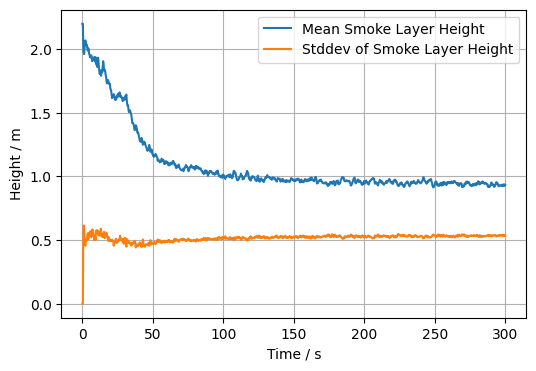

In [42]:
# plot the mean and stddev values as functions of time
plt.plot(slc.times, layer_mean, label='Mean Smoke Layer Height')
plt.plot(slc.times, layer_stddev, label='Stddev of Smoke Layer Height')
plt.grid()
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Height / m')

# save output to file
plt.savefig('figs/appartment_layer_mean_stddev.svg', bbox_inches='tight')

plt.close()

<!-- :::{figure-md} fig-example-dataanalysis2-layer-mean-stddev

<img src="figs/appartment_layer_mean_stddev.svg" width="100%">

Temporal development of the mean and stdandard deviation of the smoke layer height.
::: -->

Both values can be combined and visualised jointly, where the standard deviation is used to indicate a fluctuation band around the mean value.

In [43]:
# plot the mean
plt.plot(slc.times, layer_mean, label='Mean Smoke Layer Height')

# plot a band around the mean, using the stddev as band borders
plt.fill_between(slc.times, layer_mean-layer_stddev, layer_mean+layer_stddev, color='C0', alpha=0.3)

# show the floor for reference
plt.ylim(bottom=0)
plt.grid()
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Height / m')

# save output to file
plt.savefig('figs/appartment_layer_mean_band.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-layer-mean-band

<img src="figs/appartment_layer_mean_band.svg" width="100%">

Temporal development of the mean and stdandard deviation of the smoke layer height.
:::

If parts of the region shall be excluded in the analysis, a coordinate dependent mask can be used for this.

In [44]:
# find indices, where the y coordinate is between the given values
ymin = 1
ymax = 4
coord_mask = np.where((slc_coords['y'] > ymin) & (slc_coords['y'] < ymax))

In [49]:
# slice data
plt.imshow(slc_data[it,:,:].T, origin='lower', vmax=200, extent=slc.extent.as_list())
plt.title(f'Temperature at t={slc.times[it]:.2f}s')
plt.xlabel('y position / m')
plt.ylabel('z position / m')
plt.colorbar(orientation='horizontal', label=f'{slc.quantity.name} / {slc.quantity.unit}' );

# smoke layer height
plt.plot(slc_coords['y'][coord_mask], layer_height[coord_mask], '.-', color='red')

# save output to file
plt.savefig('figs/appartment_temp_slice_height_mask.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-smoke-temp-slice-height-mask

<img src="figs/appartment_temp_slice_height_mask.svg" width="100%">

Temperature slice with the local smoke layer height, limited to the masked region.
:::

The above procedure can be reused, yet the computation of the mean and standard deviation is carried out on the masked values.

In [50]:
for it in range(len(slc.times)):

    res[:] = slc_coords['z'][-1]

    for ix in np.ndindex(res.shape):
        lt = np.where(slc_data[it, ix, :] > temperature_limit)[1]
        if len(lt) > 0:
            res[ix] = slc_coords['z'][lt[0]]
    
    # computation is carried out on the masked values now
    layer_mean[it] = np.mean(res[coord_mask])
    layer_stddev[it] = np.std(res[coord_mask])

In [52]:
# same plot as above
plt.plot(slc.times, layer_mean, label='Mean Smoke Layer Height')
plt.fill_between(slc.times, layer_mean-layer_stddev, layer_mean+layer_stddev, color='C0', alpha=0.3)
plt.ylim(bottom=0)
plt.grid()
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Height / m')

# save output to file
plt.savefig('figs/appartment_layer_mean_band_mask.svg', bbox_inches='tight')

plt.close()

:::{figure-md} fig-example-dataanalysis2-layer-mean-band-mask

<img src="figs/appartment_layer_mean_band_mask.svg" width="100%">

Temporal development of the mean and stdandard deviation of the smoke layer height in the masked region.
:::